In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell

# Hyperparameters

In [13]:
test_length = 1500
sampling_rate = 200
striding = 100

In [3]:
def downgrade_and_feature(array):
    nchannels = array.shape[0]
    data_length = array.shape[1]
    
    temp = np.zeros(data_length)
    
    for j in range(data_length):
        for i in range(nchannels):
            temp[j] += array[i][j]
        temp[j]/=nchannels
    
    reduced_length = int(data_length/striding)

    averages = np.zeros(reduced_length, dtype = np.float32)   
    variations = np.zeros(reduced_length, dtype = np.float32)
    
    for i in range(reduced_length):
        averages[i] = np.average(temp[striding*i:striding*(i+1)])
        variations[i] = np.var(temp[striding*i:striding*(i+1)])
        
    return {'averages' : averages,'variations' : variations}

In [4]:
def dataload(patient_number, iswakeup=0):
    try :
        input_folder_path = '/home/maestoj/medical_analysis/eeg_normal'
        input_data_name = 'data{}s.csv'.format(patient_number)
        if iswakeup == 1:
            input_data_name = 'data{}w.csv'.format(patient_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [5]:
def time_axis_maker(array, sec_per_cell,init = 0):
    final = init + sec_per_cell*(len(array)-1)
    return np.linspace(init,final,len(array))

In [9]:
temp = dataload(1,1)
print(temp.shape)
result = downgrade_and_feature(temp)
print(result['averages'].shape)
print(result['variations'].shape)

data1w.csv is loaded
(22, 28800)
(288,)
(288,)


In [16]:
def test_set_generator(patient_number, iswakeup=0):
    result = downgrade_and_feature(dataload(patient_number,iswakeup))
    
    original_length = len(result['averages'])
    input_data = np.zeros((2,test_length))
    for i in range(test_length):
        index = i%original_length
        input_data[0][i] = result['averages'][index]
        input_data[1][i] = result['variations'][index]

    return input_data

data1s.csv is loaded


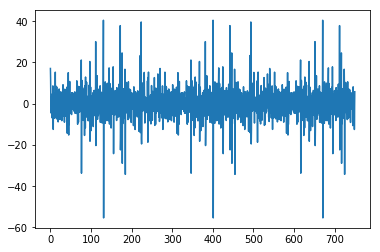

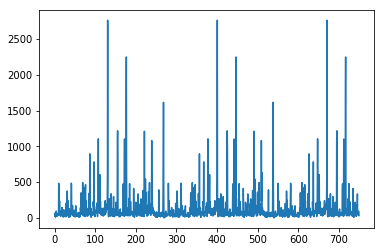

In [18]:
result = test_set_generator(1,0)
time = time_axis_maker(result[0], striding/sampling_rate)
plt.plot(time,result[0])
plt.show()
plt.plot(time, result[1])
plt.show()

In [11]:
restorer = tf.train.import_meta_graph('rnn_v5.meta')
sess = tf.Session()
restorer.restore(sess, tf.train.latest_checkpoint('./'))
hypo_vars = tf.get_collection('hypothesis')
input_vars = tf.get_collection('test_input')
test_x = input_vars[0]
temp_test_outputs = hypo_vars[0]

KeyboardInterrupt: 

In [ ]:
print("Patient {} and dataset {}".format(test_patient_number+1,test_dataset_number+1))
print("seizure_time = {}".format(onset_time_temp))
result = test_set_generator(test_patient_number+1, test_dataset_number+1)
input_data = result['input']
time = time_axis_maker(input_data[0],striding/sampling_rate)
plt.plot(time, sess.run(temp_test_outputs, feed_dict = {test_x : input_data}))
plt.show()